# Miniproject 1: Image Classification

## Introduction


### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://yann.lecun.com/exdb/mnist/). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://github.com/keras-team/keras/tree/master/examples) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "convolutional neural network", "training and validation data", "overfitting" and "early stopping".

In [232]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam

### Plotting

In [64]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j])%10, color='green',   ##removed +1
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',     ##
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig

## Exercise 1: Data import and visualization (4 points)

### Description

### Loading the data

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets.

1. As a warm-up exercise, use this importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the corresponding plotting function defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (1 sentence max.) (2 pts)

The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish.



### Solution

In [233]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

plot some random samples from MNIST


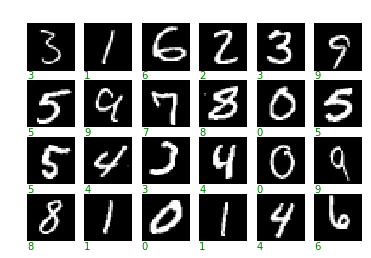

In [234]:
plot_some_samples(x_train , y_train)
print("plot some random samples from MNIST")

plot some random samples from Fashion-MNIST


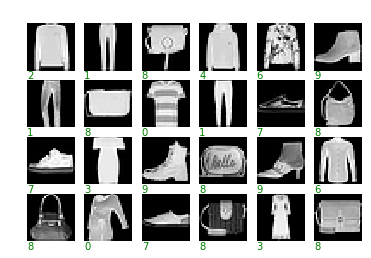

In [44]:
plot_some_samples(x_fashion_train  , y_fashion_train)
print("plot some random samples from Fashion-MNIST")

Answer to question 2: green digits at the bottom left of each image indicate the true label (corresponding class) of the corresponding image

**Data pre-processing**: To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing). Furthermore we reshape (flatten) the input images to input vectors and rescale the data into the range [0,1].

In [45]:
x_train.shape

(60000, 28, 28)

In [235]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_fashion_train = keras.utils.to_categorical(y_fashion_train)
y_fashion_test = keras.utils.to_categorical(y_fashion_test)

In [236]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/np.max(x_train)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/np.max(x_test)

x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], x_fashion_train.shape[1]*x_fashion_train.shape[2])/np.max(x_fashion_train)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], x_fashion_test.shape[1]*x_fashion_test.shape[2])/np.max(x_fashion_test)

In [179]:
x_train.shape

(60000, 784)

## Exercise 2: No hidden layer (10 points)

### Description

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). (1 pt for each step)

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices)`. Explain the green and red digits at the bottom of each image.
9. Repeat the above steps for fitting the network to the Fashion-MNIST dataset.


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

In [49]:
from __future__ import print_function

#import keras
#from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop , SGD

In [50]:
batch_size = 128
num_classes = 10
epochs = 360

In [58]:
model = Sequential()
model.add(Dense(num_classes, activation='softmax', input_shape=(784,) ))


In [59]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [60]:
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

In [61]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/360
60000/60000 [==============================] - 3s 57us/step - loss: 1.3168 - acc: 0.6689 - val_loss: 0.8220 - val_acc: 0.8265
Epoch 2/360
60000/60000 [==============================] - 1s 12us/step - loss: 0.7231 - acc: 0.8377 - val_loss: 0.6099 - val_acc: 0.8617
Epoch 3/360
60000/60000 [==============================] - 1s 12us/step - loss: 0.5898 - acc: 0.8586 - val_loss: 0.5263 - val_acc: 0.8748
Epoch 4/360
60000/60000 [==============================] - 1s 14us/step - loss: 0.5267 - acc: 0.8685 - val_loss: 0.4795 - val_acc: 0.8816
Epoch 5/360
60000/60000 [==============================] - 1s 16us/step - loss: 0.4885 - acc: 0.8751 - val_loss: 0.4493 - val_acc: 0.8860
Epoch 6/360
60000/60000 [==============================] - 1s 19us/step - loss: 0.4623 - acc: 0.8800 - val_loss: 0.4279 - val_acc: 0.8917
Epoch 7/360
60000/60000 [==============================] - 1s 13us/step - loss: 0.4429 - acc: 0.8837 - val_loss: 0.4117 - 

Epoch 118/360
60000/60000 [==============================] - 1s 12us/step - loss: 0.2824 - acc: 0.9216 - val_loss: 0.2792 - val_acc: 0.9216
Epoch 119/360
60000/60000 [==============================] - 1s 16us/step - loss: 0.2822 - acc: 0.9216 - val_loss: 0.2791 - val_acc: 0.9211
Epoch 120/360
60000/60000 [==============================] - 1s 12us/step - loss: 0.2820 - acc: 0.9219 - val_loss: 0.2789 - val_acc: 0.9213
Epoch 121/360
60000/60000 [==============================] - 1s 12us/step - loss: 0.2818 - acc: 0.9218 - val_loss: 0.2787 - val_acc: 0.9208
Epoch 122/360
60000/60000 [==============================] - 1s 11us/step - loss: 0.2815 - acc: 0.9217 - val_loss: 0.2788 - val_acc: 0.9213
Epoch 123/360
60000/60000 [==============================] - 1s 12us/step - loss: 0.2813 - acc: 0.9221 - val_loss: 0.2783 - val_acc: 0.9212
Epoch 124/360
60000/60000 [==============================] - 1s 12us/step - loss: 0.2812 - acc: 0.9218 - val_loss: 0.2784 - val_acc: 0.9216
Epoch 125/360
60000/

60000/60000 [==============================] - 1s 12us/step - loss: 0.2667 - acc: 0.9264 - val_loss: 0.2707 - val_acc: 0.9226
Epoch 235/360
60000/60000 [==============================] - 1s 11us/step - loss: 0.2666 - acc: 0.9265 - val_loss: 0.2707 - val_acc: 0.9230
Epoch 236/360
60000/60000 [==============================] - 1s 11us/step - loss: 0.2666 - acc: 0.9265 - val_loss: 0.2706 - val_acc: 0.9233
Epoch 237/360
60000/60000 [==============================] - 1s 11us/step - loss: 0.2664 - acc: 0.9263 - val_loss: 0.2705 - val_acc: 0.9232
Epoch 238/360
60000/60000 [==============================] - 1s 12us/step - loss: 0.2664 - acc: 0.9266 - val_loss: 0.2706 - val_acc: 0.9231
Epoch 239/360
60000/60000 [==============================] - 1s 12us/step - loss: 0.2663 - acc: 0.9265 - val_loss: 0.2706 - val_acc: 0.9231
Epoch 240/360
60000/60000 [==============================] - 1s 11us/step - loss: 0.2662 - acc: 0.9266 - val_loss: 0.2704 - val_acc: 0.9231
Epoch 241/360
60000/60000 [=======

60000/60000 [==============================] - 1s 12us/step - loss: 0.2591 - acc: 0.9287 - val_loss: 0.2677 - val_acc: 0.9249
Epoch 351/360
60000/60000 [==============================] - 1s 14us/step - loss: 0.2590 - acc: 0.9289 - val_loss: 0.2677 - val_acc: 0.9247
Epoch 352/360
60000/60000 [==============================] - 1s 14us/step - loss: 0.2590 - acc: 0.9288 - val_loss: 0.2677 - val_acc: 0.9238
Epoch 353/360
60000/60000 [==============================] - 1s 14us/step - loss: 0.2589 - acc: 0.9288 - val_loss: 0.2676 - val_acc: 0.9247
Epoch 354/360
60000/60000 [==============================] - 1s 12us/step - loss: 0.2589 - acc: 0.9289 - val_loss: 0.2677 - val_acc: 0.9242
Epoch 355/360
60000/60000 [==============================] - 1s 12us/step - loss: 0.2588 - acc: 0.9291 - val_loss: 0.2675 - val_acc: 0.9239
Epoch 356/360
60000/60000 [==============================] - 1s 12us/step - loss: 0.2588 - acc: 0.9290 - val_loss: 0.2675 - val_acc: 0.9248
Epoch 357/360
60000/60000 [=======

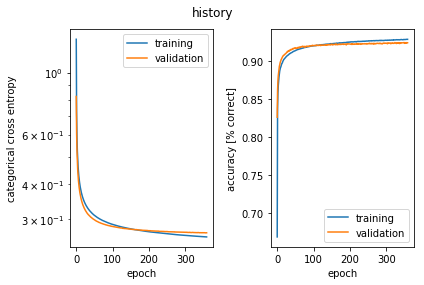

In [62]:
plot_history(history, 'history')
plt.show()

we do not see further noticable decrease in validation loss afther around epoch 250

In [71]:
yhat_test = np.argmax(model.predict_on_batch(x_test),axis=1)
wrong_ind = np.not_equal(yhat_test,np.argmax(y_test,axis=1))
error_indices = (np.argwhere(wrong_ind==True))
error_indices = np.ravel(error_indices)
#print(np.count_nonzero(wrong_ind))


plot some wrong predicted samples from MNIST


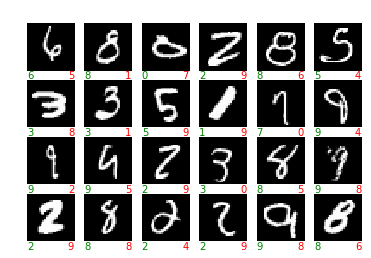

In [81]:
plot_some_samples(x_test, y_test, yhat_test, error_indices)
print("plot some wrong predicted samples from MNIST")

### Fashion Mnist:

In [75]:
model_fashion = Sequential()
model_fashion.add(Dense(num_classes, activation='softmax', input_shape=(784,) ))
model_fashion.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [76]:
model_fashion.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

In [77]:
epochs = 400

history_fashion = model_fashion.fit(x_fashion_train, y_fashion_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_fashion_test, y_fashion_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/400
60000/60000 [==============================] - 4s 65us/step - loss: 1.1389 - acc: 0.6668 - val_loss: 0.8604 - val_acc: 0.7243
Epoch 2/400
60000/60000 [==============================] - 1s 16us/step - loss: 0.7738 - acc: 0.7607 - val_loss: 0.7424 - val_acc: 0.7567
Epoch 3/400
60000/60000 [==============================] - 1s 20us/step - loss: 0.6905 - acc: 0.7841 - val_loss: 0.6847 - val_acc: 0.7752
Epoch 4/400
60000/60000 [==============================] - 1s 17us/step - loss: 0.6454 - acc: 0.7957 - val_loss: 0.6495 - val_acc: 0.7860
Epoch 5/400
60000/60000 [==============================] - 1s 14us/step - loss: 0.6154 - acc: 0.8039 - val_loss: 0.6251 - val_acc: 0.7946
Epoch 6/400
60000/60000 [==============================] - 1s 12us/step - loss: 0.5933 - acc: 0.8104 - val_loss: 0.6072 - val_acc: 0.7992
Epoch 7/400
60000/60000 [==============================] - 1s 14us/step - loss: 0.5764 - acc: 0.8140 - val_loss: 0.5945 - 

Epoch 118/400
60000/60000 [==============================] - 1s 18us/step - loss: 0.4103 - acc: 0.8606 - val_loss: 0.4528 - val_acc: 0.8404
Epoch 119/400
60000/60000 [==============================] - 1s 16us/step - loss: 0.4102 - acc: 0.8607 - val_loss: 0.4520 - val_acc: 0.8410
Epoch 120/400
60000/60000 [==============================] - 1s 17us/step - loss: 0.4098 - acc: 0.8607 - val_loss: 0.4529 - val_acc: 0.8410
Epoch 121/400
60000/60000 [==============================] - 1s 15us/step - loss: 0.4095 - acc: 0.8605 - val_loss: 0.4523 - val_acc: 0.8409
Epoch 122/400
60000/60000 [==============================] - 1s 16us/step - loss: 0.4092 - acc: 0.8605 - val_loss: 0.4519 - val_acc: 0.8402
Epoch 123/400
60000/60000 [==============================] - 1s 16us/step - loss: 0.4090 - acc: 0.8608 - val_loss: 0.4519 - val_acc: 0.8408
Epoch 124/400
60000/60000 [==============================] - 1s 12us/step - loss: 0.4089 - acc: 0.8609 - val_loss: 0.4513 - val_acc: 0.8405
Epoch 125/400
60000/

60000/60000 [==============================] - 1s 11us/step - loss: 0.3917 - acc: 0.8656 - val_loss: 0.4409 - val_acc: 0.8440
Epoch 235/400
60000/60000 [==============================] - 1s 11us/step - loss: 0.3916 - acc: 0.8663 - val_loss: 0.4412 - val_acc: 0.8444
Epoch 236/400
60000/60000 [==============================] - 1s 11us/step - loss: 0.3915 - acc: 0.8658 - val_loss: 0.4407 - val_acc: 0.8445
Epoch 237/400
60000/60000 [==============================] - 1s 11us/step - loss: 0.3913 - acc: 0.8662 - val_loss: 0.4412 - val_acc: 0.8432
Epoch 238/400
60000/60000 [==============================] - 1s 11us/step - loss: 0.3913 - acc: 0.8655 - val_loss: 0.4421 - val_acc: 0.8434
Epoch 239/400
60000/60000 [==============================] - 1s 13us/step - loss: 0.3912 - acc: 0.8658 - val_loss: 0.4407 - val_acc: 0.8443
Epoch 240/400
60000/60000 [==============================] - 1s 12us/step - loss: 0.3911 - acc: 0.8657 - val_loss: 0.4408 - val_acc: 0.8442
Epoch 241/400
60000/60000 [=======

60000/60000 [==============================] - 1s 13us/step - loss: 0.3824 - acc: 0.8684 - val_loss: 0.4369 - val_acc: 0.8439
Epoch 351/400
60000/60000 [==============================] - 1s 13us/step - loss: 0.3824 - acc: 0.8684 - val_loss: 0.4371 - val_acc: 0.8453
Epoch 352/400
60000/60000 [==============================] - 1s 14us/step - loss: 0.3823 - acc: 0.8686 - val_loss: 0.4378 - val_acc: 0.8449
Epoch 353/400
60000/60000 [==============================] - 1s 13us/step - loss: 0.3823 - acc: 0.8685 - val_loss: 0.4367 - val_acc: 0.8453
Epoch 354/400
60000/60000 [==============================] - 1s 16us/step - loss: 0.3822 - acc: 0.8687 - val_loss: 0.4379 - val_acc: 0.8443
Epoch 355/400
60000/60000 [==============================] - 1s 16us/step - loss: 0.3821 - acc: 0.8683 - val_loss: 0.4370 - val_acc: 0.8452
Epoch 356/400
60000/60000 [==============================] - 3s 52us/step - loss: 0.3820 - acc: 0.8686 - val_loss: 0.4370 - val_acc: 0.8448
Epoch 357/400
60000/60000 [=======

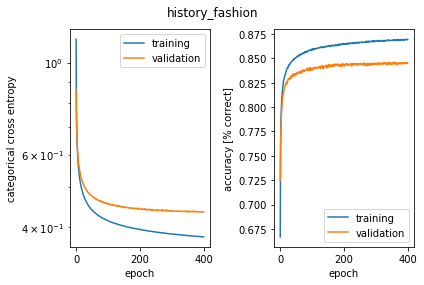

In [78]:
plot_history(history_fashion, 'history_fashion')
plt.show()

we do not see further noticable decrease in validation loss afther around epoch 300

In [79]:
yhat_fashion_test = np.argmax(model_fashion.predict_on_batch(x_fashion_test),axis=1)
wrong_fashion_ind = np.not_equal(yhat_fashion_test,np.argmax(y_fashion_test,axis=1))
error_fashion_indices = (np.argwhere(wrong_fashion_ind==True))
error_fashion_indices = np.ravel(error_fashion_indices)

plot some wrong predicted samples from Fashion MNIST


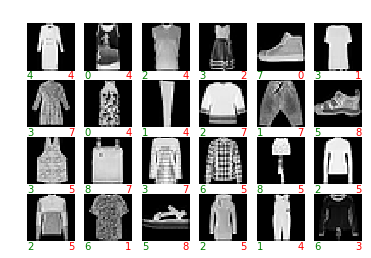

In [80]:
plot_some_samples(x_fashion_test, y_fashion_test, yhat_fashion_test, error_fashion_indices)
print("plot some wrong predicted samples from Fashion MNIST")

#### Answer to question 10:  the green digits are the correct class (or correct labels ) while the red digits are the predicted class (output of our network) for this wrong labaled samples

## Exercise 3: One hidden layer, different optizimizers & overfitting (10 points)

### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to display your model in a compact way. (1 pt)
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD). (1pt)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam). (1pt)
4. Plot the learning curves of SGD with a reasonable learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (2pts)
5. Answer the questions below. (4pts)
6. Run the network (using the Adam optimizer) on the Fashion-MNIST dataset and plot the learning curves using the plot_history function defined above. (1pt)

### Solution

In [84]:
batch_size = 128
epochs = 50 

In [97]:

# SGD with learning rate 0.1

model_SGD_1 = Sequential()
model_SGD_1.add(Dense(128, activation='relu', input_shape=(784,)))
model_SGD_1.add(Dense(num_classes, activation='softmax'))
model_SGD_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_50 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [120]:
# array of learning rates
    # 2 : too big
    # 0.0001 : too small
LR_Array = [2, 0.1, 0.01, 0.001, 0.0001]    

history_Array = np.array([])

model_Array = []

for i in range(len(LR_Array)):
    model_Array.append(Sequential())


epochs = 50

i = 0
for LR in LR_Array:
    print('SGD with learning rate : ', LR)
    model_Array[i].add(Dense(128, activation='relu', input_shape=(784,)))
    model_Array[i].add(Dense(num_classes, activation='softmax'))

    model_Array[i].compile(loss='categorical_crossentropy',
                  optimizer=SGD(lr=LR),
                  metrics=['accuracy'])


    history_new = model_Array[i].fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        validation_data=(x_test, y_test))
    
    history_Array = np.append(history_Array, history_new)
    print('  Final accuracy for validation data : ' , 100*history_Array[i].history['val_acc'][-1] ,'%')
    print('  Final accuracy for training data : ' , 100*history_Array[i].history['acc'][-1] ,'%')
    
    i = i+1


SGD with learning rate :  2
  Final accuracy for validation data :  10.100000000000001 %
  Final accuracy for training data :  10.218333334128062 %
SGD with learning rate :  0.1
  Final accuracy for validation data :  98.08 %
  Final accuracy for training data :  99.82166666666666 %
SGD with learning rate :  0.01
  Final accuracy for validation data :  95.67999999999999 %
  Final accuracy for training data :  96.03833333651225 %
SGD with learning rate :  0.001
  Final accuracy for validation data :  90.82000000000001 %
  Final accuracy for training data :  90.36166666666666 %
SGD with learning rate :  0.0001
  Final accuracy for validation data :  81.77 %
  Final accuracy for training data :  81.1149999968211 %


#### The best SGD result was with learning rate 0.1

SGD with learning rate 0.1  : 
  Final accuracy of for validation data :  98.08 %
  Final accuracy for training data :  99.82166666666666 %


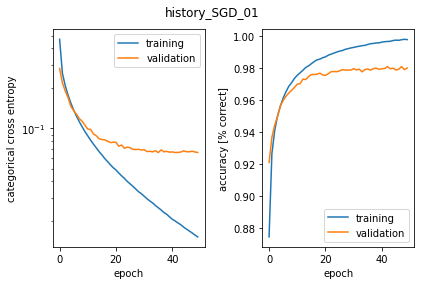

In [170]:

i = 1

print('SGD with learning rate',  LR_Array [i],' : ')

print('  Final accuracy of for validation data : ' , 100* history_Array[i].history['val_acc'][-1],'%')

print('  Final accuracy for training data : ' , 100* history_Array[i].history['acc'][-1] ,'%')

plot_history(history_SGD_1, 'history_SGD_01')


plt.show()

#### Adam

In [181]:
epochs = 50

model_Adam = Sequential()
model_Adam.add(Dense(128, activation='relu', input_shape=(784,)))
model_Adam.add(Dense(num_classes, activation='softmax'))

model_Adam.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])


history_Adam = model_Adam.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 5s 85us/step - loss: 0.3594 - acc: 0.9002 - val_loss: 0.1994 - val_acc: 0.9454
Epoch 2/50
60000/60000 [==============================] - 2s 28us/step - loss: 0.1656 - acc: 0.9533 - val_loss: 0.1380 - val_acc: 0.9601
Epoch 3/50
60000/60000 [==============================] - 2s 30us/step - loss: 0.1177 - acc: 0.9666 - val_loss: 0.1134 - val_acc: 0.9655
Epoch 4/50
60000/60000 [==============================] - 2s 28us/step - loss: 0.0907 - acc: 0.9740 - val_loss: 0.1021 - val_acc: 0.9695
Epoch 5/50
60000/60000 [==============================] - 2s 30us/step - loss: 0.0729 - acc: 0.9795 - val_loss: 0.0853 - val_acc: 0.9746
Epoch 6/50
60000/60000 [==============================] - 2s 30us/step - loss: 0.0602 - acc: 0.9822 - val_loss: 0.0828 - val_acc: 0.9742
Epoch 7/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.0512 - acc: 0.9847 - val_loss: 0.0842 - val_acc

Final accuracy of  Adam for validation data :  98.04 %
Final accuracy of  Adam for training data :  100.0 %


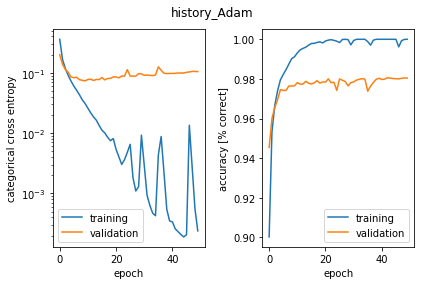

In [182]:
print('Final accuracy of ' ,'Adam','for validation data : ' , 100*history_Adam.history['val_acc'][-1] ,'%')

print('Final accuracy of ' ,'Adam', 'for training data : ' , 100* history_Adam.history['acc'][-1] ,'%')

plot_history(history_Adam, 'history_Adam')
plt.show()

In [184]:
# This plotting routine might help you ...
def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    ax1.plot(history_sgd.history['loss'], label=label1 + ' training')
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' validation')
    ax1.plot(history_adam.history['loss'], label=label2 + ' training')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' validation')
    ax2.plot(history_sgd.history['acc'], label=label1 + ' training')
    ax2.plot(history_sgd.history['val_acc'], label=label1 + ' validation')
    ax2.plot(history_adam.history['acc'], label=label2 + ' training')
    ax2.plot(history_adam.history['val_acc'], label=label2 + ' validation')
    finalize_standardplot(fig, ax1, ax2)
    return fig

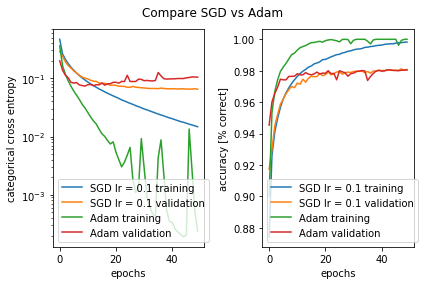

In [188]:

fig = comparison_plot(history_Array[1], history_Adam , 'SGD lr = 0.1' , 'Adam' , 'Compare SGD vs Adam')


Final accuracy of  SGD with learnninng rate 2 (Too Big) for validation data :  10.100000000000001 %


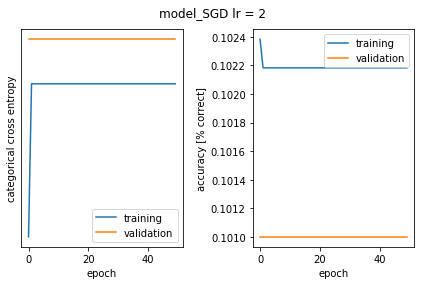

no convergence and the result is same as random guess


In [194]:
print('Final accuracy of ' ,'SGD with learnninng rate 2 (Too Big)','for validation data : ' , 100*history_Array[0].history['val_acc'][-1],'%')
plot_history(history_Array[0], 'model_SGD lr = 2')
plt.show()

print('no convergence and the result is same as random guess')

Final accuracy of  SGD with learnninng rate 0.0001 (Too Small) for validation data :  81.77 %


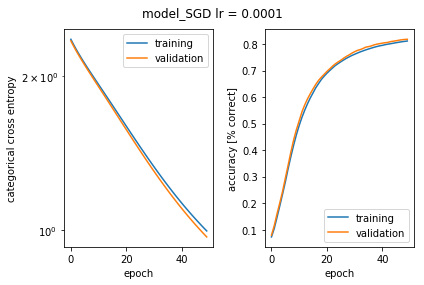

slow convergence


In [195]:
print('Final accuracy of ' ,'SGD with learnninng rate 0.0001 (Too Small)','for validation data : ' , 100*history_Array[4].history['val_acc'][-1],'%')
plot_history (history_Array[4], 'model_SGD lr = 0.0001')
plt.show()

print('slow convergence')

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence each (double click this markdown cell to edit).

**Answer**:

A) If the learning rate of SGD is Very Small we have a very small rate of convergence and the convergence would be slow.

B) If the learning rate of SGD is very large we would end up with repeatedly hopping back and forth over the valley and we would not convergence to the optimal.

**Question**: At which epoch (approximately) does the Adam optimizer start to overfit (on MNIST)? Please answer with one full sentence.

**Answer**: around epoch 12 the Adam optimizer start to overfit

**Question**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: 
The performance of a model usually is determined by its ability to perform well on unseen data, then overfitting occurs when a model begins to "memorize" training data rather than "learning" to generalize from a trend. we can identify this behavior by looking at the loss curves and accuracy curves over the number of epochs, the validation loss curve will decrease over the number of epochs before the overfitting and then the validation loss will increase. the validation accuracy curve will increase over the number of epochs before the overfitting and then it will decrease (or stay around the same value), the overfitting can be identified easier by looking at the loss curves.

In [87]:
#Adam on fashion MNIST
model_Adam_fashion = Sequential()
model_Adam_fashion.add(Dense(128, activation='relu', input_shape=(784,)))
model_Adam_fashion.add(Dense(num_classes, activation='softmax'))

model_Adam_fashion.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])


history_Adam_fashion = model_Adam_fashion.fit(x_fashion_train, y_fashion_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_fashion_test, y_fashion_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 61us/step - loss: 0.5526 - acc: 0.8106 - val_loss: 0.4663 - val_acc: 0.8386
Epoch 2/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.4066 - acc: 0.8582 - val_loss: 0.4249 - val_acc: 0.8493
Epoch 3/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.3693 - acc: 0.8697 - val_loss: 0.4218 - val_acc: 0.8486
Epoch 4/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.3455 - acc: 0.8767 - val_loss: 0.3824 - val_acc: 0.8617
Epoch 5/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.3250 - acc: 0.8838 - val_loss: 0.3743 - val_acc: 0.8680
Epoch 6/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.3099 - acc: 0.8881 - val_loss: 0.3540 - val_acc: 0.8752
Epoch 7/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.2969 - acc: 0.8918 - val_loss: 0.3465 - val_acc

Final accuracy of  Adam on Fashion MNIST  for validation data :  88.8 %


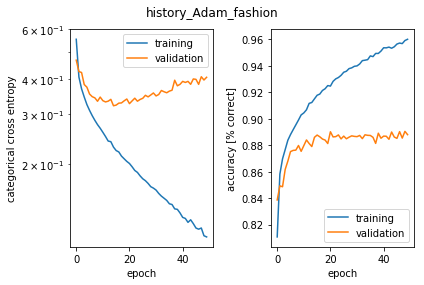

In [88]:
print('Final accuracy of ' ,'Adam on Fashion MNIST ','for validation data : ' , 100*history_Adam_fashion.history['val_acc'][-1] ,'%')
plot_history(history_Adam_fashion, 'history_Adam_fashion')
plt.show()

## Exercise 4: Model performance as a function of number of hidden neurons (8 points)

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models (e.g. 5) with different hidden layer sizes (between 10 and 1000 hidden neurons) to the MNIST dataset. You may use the Adam optimizer and a meaningful number of epochs (overfitting!). (3 pts)
2. Plot the best validation loss and accuracy versus the number of hidden neurons. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? If not, what might be practical reasons for the deviation? (2 sentences max.) (3 pts)
3. Repeat steps 1. & 2. for the Fashion-MNIST dataset. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

### Solution

#### for MNIST

In [123]:

num_of_neurons_Array = [10, 128, 256, 512, 768, 1000]

history_Adam_Array = np.array([])

model_Adam_Array = []

for i in range(len(num_of_neurons_Array)):
    model_Adam_Array.append(Sequential())


epochs = 30     
i = 0
for num_of_neurons in num_of_neurons_Array:
    print('Number of neurons : ', num_of_neurons)
    model_Adam_Array[i].add(Dense(num_of_neurons, activation='relu', input_shape=(784,)))
    model_Adam_Array[i].add(Dense(num_classes, activation='softmax'))

    model_Adam_Array[i].compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])


    history_Adam_new = model_Adam_Array[i].fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        validation_data=(x_test, y_test))
    
    history_Adam_Array = np.append(history_Adam_Array, history_Adam_new)
    print('  Final loss for validation data : ' , history_Adam_Array[i].history['val_loss'][-1] )
    print('  Final accuracy for validation data : ' , 100*history_Adam_Array[i].history['val_acc'][-1] ,'%')
    print('  Final loss for training data : ' , history_Adam_Array[i].history['loss'][-1])
    print('  Final accuracy for training data : ' , 100*history_Adam_Array[i].history['acc'][-1] ,'%')
    
    i = i+1

Number of neurons :  10
  Final loss for validation data :  0.23308144414424897
  Final accuracy for validation data :  93.5 %
  Final loss for training data :  0.1954725456237793
  Final accuracy for training data :  94.45333333333333 %
Number of neurons :  128
  Final loss for validation data :  0.09036540789438732
  Final accuracy for validation data :  97.99 %
  Final loss for training data :  0.001185293045725363
  Final accuracy for training data :  99.99666666666667 %
Number of neurons :  256
  Final loss for validation data :  0.07989289761732375
  Final accuracy for validation data :  98.35000000000001 %
  Final loss for training data :  0.000287210769384789
  Final accuracy for training data :  100.0 %
Number of neurons :  512
  Final loss for validation data :  0.07706246551520744
  Final accuracy for validation data :  98.11 %
  Final loss for training data :  0.02258467417632928
  Final accuracy for training data :  99.27333333015443 %
Number of neurons :  768
  Final loss

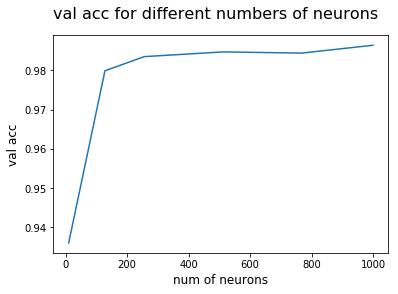

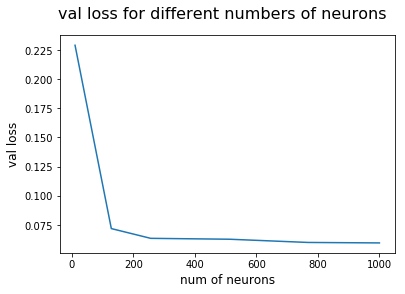

In [196]:
final_val_acc_Array = []
final_val_loss_Array = []
for i in range(len(num_of_neurons_Array)):
    #final_val_acc_Array.append(history_Adam_Array[i].history['val_acc'][-1])
    #final_val_loss_Array.append(history_Adam_Array[i].history['val_loss'][-1])
    max(history_5.history['val_acc'])
    final_val_acc_Array.append(max(history_Adam_Array[i].history['val_acc']))
    final_val_loss_Array.append(min(history_Adam_Array[i].history['val_loss']))
    
    
fig1 = plt.figure()    
plt.plot(num_of_neurons_Array,final_val_acc_Array)    
fig1.suptitle('val acc for different numbers of neurons', fontsize=16)
plt.xlabel('num of neurons', fontsize=12)
plt.ylabel('val acc', fontsize=12)
plt.show()

fig2 = plt.figure()   
plt.plot(num_of_neurons_Array,final_val_loss_Array)    
fig2.suptitle('val loss for different numbers of neurons', fontsize=16)
plt.xlabel('num of neurons', fontsize=12)
plt.ylabel('val loss', fontsize=12)
plt.show()

In [146]:
model_Adam_Array[1].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_115 (Dense)            (None, 128)               100480    
_________________________________________________________________
dense_116 (Dense)            (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


Final accuracy of  Adam_10 for validation data :  97.99 %


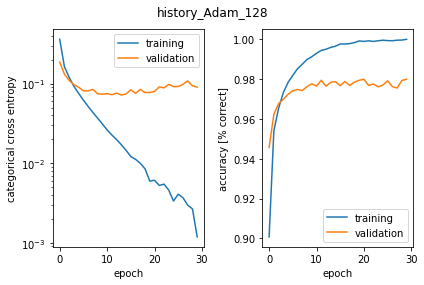

In [147]:
print('Final accuracy of ' ,'Adam_10','for validation data : ' , 100*history_Adam_Array[1].history['val_acc'][-1] ,'%')
plot_history(history_Adam_Array[1], 'history_Adam_128')
plt.show()

#### for Fashion MNIST

In [148]:
num_of_neurons_Array = [10, 128, 256, 512, 768, 1000]

history_Adam_fashion_Array = np.array([])

model_Adam_fashion_Array = []

for i in range(len(num_of_neurons_Array)):
    model_Adam_fashion_Array.append(Sequential())


epochs = 50     
i = 0
for num_of_neurons in num_of_neurons_Array:
    print('Number of neurons for fashion MNIST : ', num_of_neurons)
    model_Adam_fashion_Array[i].add(Dense(num_of_neurons, activation='relu', input_shape=(784,)))
    model_Adam_fashion_Array[i].add(Dense(num_classes, activation='softmax'))

    model_Adam_fashion_Array[i].compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])


    history_Adam_fashion_new = model_Adam_fashion_Array[i].fit(x_fashion_train, y_fashion_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        validation_data=(x_fashion_test, y_fashion_test))
    
    history_Adam_fashion_Array = np.append(history_Adam_fashion_Array, history_Adam_fashion_new)
    print('  Final loss for validation data : ' , history_Adam_fashion_Array[i].history['val_loss'][-1] )
    print('  Final accuracy for validation data : ' , 100*history_Adam_fashion_Array[i].history['val_acc'][-1] ,'%')
    print('  Final loss for training data : ' , history_Adam_fashion_Array[i].history['loss'][-1])
    print('  Final accuracy for training data : ' , 100*history_Adam_fashion_Array[i].history['acc'][-1] ,'%')
    
    i = i+1

Number of neurons for fashion MNIST :  10
  Final loss for validation data :  0.440938064289093
  Final accuracy for validation data :  84.17 %
  Final loss for training data :  0.33275627331733704
  Final accuracy for training data :  88.18 %
Number of neurons for fashion MNIST :  128
  Final loss for validation data :  0.3931562150478363
  Final accuracy for validation data :  88.63 %
  Final loss for training data :  0.10690382522145907
  Final accuracy for training data :  96.08666666348775 %
Number of neurons for fashion MNIST :  256
  Final loss for validation data :  0.4323300437927246
  Final accuracy for validation data :  89.25 %
  Final loss for training data :  0.07995129922032357
  Final accuracy for training data :  97.04666666348776 %
Number of neurons for fashion MNIST :  512
  Final loss for validation data :  0.4644629912137985
  Final accuracy for validation data :  89.17 %
  Final loss for training data :  0.06741254666248957
  Final accuracy for training data :  97

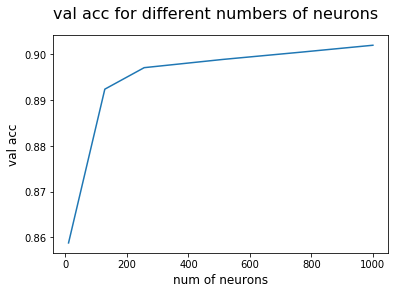

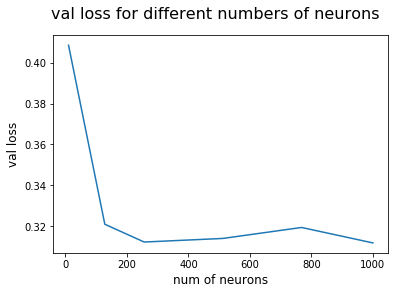

In [197]:
final_fashion_val_acc_Array = []
final_fashion_val_loss_Array = []
for i in range(len(num_of_neurons_Array)):
    #final_fashion_val_acc_Array.append(history_Adam_fashion_Array[i].history['val_acc'][-1])
    #final_fashion_val_loss_Array.append(history_Adam_fashion_Array[i].history['val_loss'][-1])
    max(history_5.history['val_acc'])
    final_fashion_val_acc_Array.append(max(history_Adam_fashion_Array[i].history['val_acc']))
    final_fashion_val_loss_Array.append(min(history_Adam_fashion_Array[i].history['val_loss']))
    
    
fig1 = plt.figure()    
plt.plot(num_of_neurons_Array,final_fashion_val_acc_Array)    
fig1.suptitle('val acc for different numbers of neurons', fontsize=16)
plt.xlabel('num of neurons', fontsize=12)
plt.ylabel('val acc', fontsize=12)
plt.show()

fig2 = plt.figure()   
plt.plot(num_of_neurons_Array,final_fashion_val_loss_Array)    
fig2.suptitle('val loss for different numbers of neurons', fontsize=16)
plt.xlabel('num of neurons', fontsize=12)
plt.ylabel('val loss', fontsize=12)
plt.show()



#### Answer to question 2:
#### The Universal approximation theorem states that a feed-forward neural network with a single hidden layer (with enough number of neurons) can approximate many interesting functions when given appropriate parameters. But this theorem does not touch upon the learnability of those parameters and obviously, with a higher number of neurons (more parameters) we would need more training samples.  our results more or less follow the universal approximation theorem in which we have better results with more number of neurons, but it should be noted that with higher number of neurons (more parameters) more training samples are needed for learning so it could also be seen that the performance of the model decreases with adding too many neurons if the number of training samples is constant.

## Exercise 5: Going deeper: tricks and regularization (8 points)

### Description

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. Overfitting can be counteracted with regularization and dropout. Batch normalization is supposed to mainly speed up convergence. Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network we use the Fashion-MNIST dataset in this exercise.

1. Add one or two hidden layers with 50 hidden neurons (each) and train the network for a sufficiently long time (at least 100 epochs). Since deep models are very expressive you will most probably encounter overfitting. Try to improve the best validation scores of the model (even if it is only a minor improvement) by experimenting with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases. (4 pts)
2. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized), preferably together in a comparison plot. Discuss your results; refer to the model performance with only 1 hidden layer. (2 sentences max.) (2pts)
3. Fit your best performing (probably regularized deep) model also to MNIST for having a reference for the next exercise. Plot the resulting learning curves. (2 pts)

### Solution

In [237]:
# two hidden layers
epochs = 200

model_5_first = Sequential()
model_5_first.add(Dense(128, activation='relu', input_shape=(784,)))
model_5_first.add(Dense(50, activation='relu'))
model_5_first.add(Dense(num_classes, activation='softmax'))

model_5_first.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history_5_first = model_5_first.fit(x_fashion_train, y_fashion_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_fashion_test, y_fashion_test))



Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 8s 139us/step - loss: 0.5416 - acc: 0.8142 - val_loss: 0.4515 - val_acc: 0.8400
Epoch 2/200
60000/60000 [==============================] - 2s 32us/step - loss: 0.3930 - acc: 0.8601 - val_loss: 0.4013 - val_acc: 0.8588
Epoch 3/200
60000/60000 [==============================] - 2s 35us/step - loss: 0.3539 - acc: 0.8719 - val_loss: 0.3851 - val_acc: 0.8612
Epoch 4/200
60000/60000 [==============================] - 2s 32us/step - loss: 0.3243 - acc: 0.8817 - val_loss: 0.3805 - val_acc: 0.8645
Epoch 5/200
60000/60000 [==============================] - 2s 31us/step - loss: 0.3064 - acc: 0.8891 - val_loss: 0.3692 - val_acc: 0.8684
Epoch 6/200
60000/60000 [==============================] - 2s 31us/step - loss: 0.2934 - acc: 0.8925 - val_loss: 0.3723 - val_acc: 0.8662
Epoch 7/200
60000/60000 [==============================] - 2s 31us/step - loss: 0.2755 - acc: 0.8976 - val_loss: 0.3561 -

Epoch 118/200
60000/60000 [==============================] - 2s 32us/step - loss: 0.0403 - acc: 0.9852 - val_loss: 0.7467 - val_acc: 0.8838
Epoch 119/200
60000/60000 [==============================] - 2s 41us/step - loss: 0.0370 - acc: 0.9860 - val_loss: 0.7548 - val_acc: 0.8841
Epoch 120/200
60000/60000 [==============================] - 2s 37us/step - loss: 0.0380 - acc: 0.9859 - val_loss: 0.7618 - val_acc: 0.8839
Epoch 121/200
60000/60000 [==============================] - 2s 33us/step - loss: 0.0307 - acc: 0.9889 - val_loss: 0.7681 - val_acc: 0.8833
Epoch 122/200
60000/60000 [==============================] - 2s 32us/step - loss: 0.0337 - acc: 0.9874 - val_loss: 0.7440 - val_acc: 0.8816
Epoch 123/200
60000/60000 [==============================] - 2s 30us/step - loss: 0.0410 - acc: 0.9844 - val_loss: 0.7304 - val_acc: 0.8874
Epoch 124/200
60000/60000 [==============================] - 2s 32us/step - loss: 0.0301 - acc: 0.9884 - val_loss: 0.7556 - val_acc: 0.8851
Epoch 125/200
60000/

Final accuracy for validation data :  88.64999999999999 %
Final accuracy for training data :  98.8849999968211 %


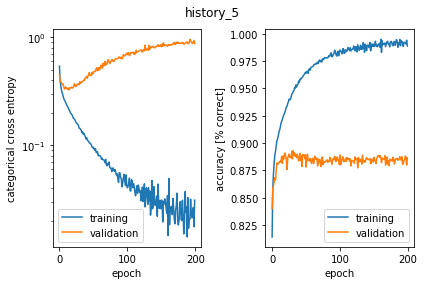

In [238]:
print('Final accuracy for validation data : ' , 100*history_5_first.history['val_acc'][-1] ,'%')
print('Final accuracy for training data : ' , 100*history_5_first.history['acc'][-1] ,'%')
plot_history (history_5_first, 'history_5')
plt.show()

In [13]:
# three hidden layers

epochs = 150

model_5 = Sequential()
model_5.add(Dense(128, activation='relu', input_shape=(784,)))
model_5.add(Dense(50, activation='relu'))
model_5.add(Dense(50, activation='relu'))
model_5.add(Dense(num_classes, activation='softmax'))

model_5.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history_5 = model_5.fit(x_fashion_train, y_fashion_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_fashion_test, y_fashion_test))




Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/150
60000/60000 [==============================] - 2s 32us/step - loss: 0.5877 - acc: 0.7948 - val_loss: 0.4773 - val_acc: 0.8285
Epoch 2/150
60000/60000 [==============================] - 2s 27us/step - loss: 0.3942 - acc: 0.8587 - val_loss: 0.4262 - val_acc: 0.8477
Epoch 3/150
60000/60000 [==============================] - 1s 25us/step - loss: 0.3529 - acc: 0.8716 - val_loss: 0.3670 - val_acc: 0.8686
Epoch 4/150
60000/60000 [==============================] - 1s 22us/step - loss: 0.3283 - acc: 0.8797 - val_loss: 0.3804 - val_acc: 0.8607
Epoch 5/150
60000/60000 [==============================] - 2s 25us/step - loss: 0.3075 - acc: 0.8868 - val_loss: 0.3722 - val_acc: 0.8658
Epoch 6/150
60000/60000 [==============================] - 1s 23us/step - loss: 0.2949 - acc: 0.8907 - val_loss: 0.3560 - val_acc: 0.8702
Epoch 7/150
60000/60000 [==============================] - 1s 24us/step - 

Epoch 58/150
60000/60000 [==============================] - 1s 20us/step - loss: 0.0887 - acc: 0.9656 - val_loss: 0.4926 - val_acc: 0.8879
Epoch 59/150
60000/60000 [==============================] - 1s 20us/step - loss: 0.0933 - acc: 0.9650 - val_loss: 0.5019 - val_acc: 0.8865
Epoch 60/150
60000/60000 [==============================] - 1s 20us/step - loss: 0.0878 - acc: 0.9668 - val_loss: 0.5247 - val_acc: 0.8830
Epoch 61/150
60000/60000 [==============================] - 1s 20us/step - loss: 0.0824 - acc: 0.9696 - val_loss: 0.5320 - val_acc: 0.8858
Epoch 62/150
60000/60000 [==============================] - 1s 22us/step - loss: 0.0861 - acc: 0.9673 - val_loss: 0.5285 - val_acc: 0.8872
Epoch 63/150
60000/60000 [==============================] - 1s 21us/step - loss: 0.0826 - acc: 0.9686 - val_loss: 0.5154 - val_acc: 0.8833
Epoch 64/150
60000/60000 [==============================] - 1s 20us/step - loss: 0.0795 - acc: 0.9704 - val_loss: 0.5765 - val_acc: 0.8832
Epoch 65/150
60000/60000 [=

Epoch 117/150
60000/60000 [==============================] - 1s 20us/step - loss: 0.0399 - acc: 0.9852 - val_loss: 0.7081 - val_acc: 0.8857
Epoch 118/150
60000/60000 [==============================] - 1s 21us/step - loss: 0.0463 - acc: 0.9828 - val_loss: 0.7415 - val_acc: 0.8808
Epoch 119/150
60000/60000 [==============================] - 1s 22us/step - loss: 0.0487 - acc: 0.9824 - val_loss: 0.7043 - val_acc: 0.8915
Epoch 120/150
60000/60000 [==============================] - 1s 20us/step - loss: 0.0422 - acc: 0.9851 - val_loss: 0.7453 - val_acc: 0.8832
Epoch 121/150
60000/60000 [==============================] - 1s 20us/step - loss: 0.0357 - acc: 0.9872 - val_loss: 0.7495 - val_acc: 0.8839
Epoch 122/150
60000/60000 [==============================] - 1s 20us/step - loss: 0.0443 - acc: 0.9832 - val_loss: 0.7116 - val_acc: 0.8879
Epoch 123/150
60000/60000 [==============================] - 1s 21us/step - loss: 0.0419 - acc: 0.9843 - val_loss: 0.7464 - val_acc: 0.8865
Epoch 124/150
60000/

Final accuracy for validation data :  88.5 %
Final accuracy for training data :  98.80333333651224 %


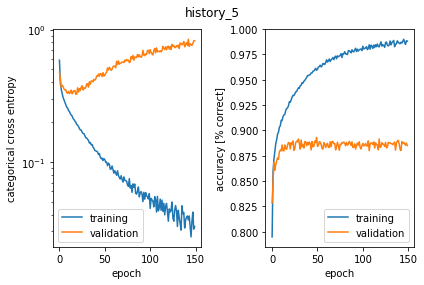

In [14]:
print('Final accuracy for validation data : ' , 100*history_5.history['val_acc'][-1] ,'%')
print('Final accuracy for training data : ' , 100*history_5.history['acc'][-1] ,'%')
plot_history (history_5, 'history_5')
plt.show()

In [20]:
# two hidden layers with regularization l2

from keras import regularizers

epochs = 300

model_5 = Sequential()
model_5.add(Dense(128, activation='relu', input_shape=(784,), kernel_regularizer=regularizers.l2(0.0004)))
model_5.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_5.add(Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

model_5.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history_5 = model_5.fit(x_fashion_train, y_fashion_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_fashion_test, y_fashion_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/300
60000/60000 [==============================] - 2s 32us/step - loss: 1.0635 - acc: 0.7979 - val_loss: 0.8267 - val_acc: 0.8244
Epoch 2/300
60000/60000 [==============================] - 1s 22us/step - loss: 0.7424 - acc: 0.8399 - val_loss: 0.7201 - val_acc: 0.8357
Epoch 3/300
60000/60000 [==============================] - 1s 22us/step - loss: 0.6777 - acc: 0.8493 - val_loss: 0.6761 - val_acc: 0.8455
Epoch 4/300
60000/60000 [==============================] - 1s 22us/step - loss: 0.6483 - acc: 0.8534 - val_loss: 0.6614 - val_acc: 0.8444
Epoch 5/300
60000/60000 [==============================] - 1s 21us/step - loss: 0.6303 - acc: 0.8560 - val_loss: 0.6554 - val_acc: 0.8436
Epoch 6/300
60000/60000 [==============================] - 1s 21us/step - loss: 0.6220 - acc: 0.8570 - val_loss: 0.6387 - val_acc: 0.8499
Epoch 7/300
60000/60000 [==============================] - 1s 21us/step - loss: 0.6138 - acc: 0.8587 - val_loss: 0.6593 - 

Epoch 118/300
60000/60000 [==============================] - 1s 21us/step - loss: 0.5683 - acc: 0.8722 - val_loss: 0.6039 - val_acc: 0.8580
Epoch 119/300
60000/60000 [==============================] - 1s 20us/step - loss: 0.5690 - acc: 0.8720 - val_loss: 0.5979 - val_acc: 0.8575
Epoch 120/300
60000/60000 [==============================] - 1s 21us/step - loss: 0.5686 - acc: 0.8714 - val_loss: 0.6053 - val_acc: 0.8577
Epoch 121/300
60000/60000 [==============================] - 1s 22us/step - loss: 0.5676 - acc: 0.8725 - val_loss: 0.6096 - val_acc: 0.8545
Epoch 122/300
60000/60000 [==============================] - 1s 21us/step - loss: 0.5677 - acc: 0.8731 - val_loss: 0.6048 - val_acc: 0.8551
Epoch 123/300
60000/60000 [==============================] - 1s 24us/step - loss: 0.5681 - acc: 0.8723 - val_loss: 0.6085 - val_acc: 0.8571
Epoch 124/300
60000/60000 [==============================] - 1s 25us/step - loss: 0.5676 - acc: 0.8727 - val_loss: 0.6036 - val_acc: 0.8536
Epoch 125/300
60000/

60000/60000 [==============================] - 1s 21us/step - loss: 0.5633 - acc: 0.8743 - val_loss: 0.6066 - val_acc: 0.8529
Epoch 235/300
60000/60000 [==============================] - 1s 21us/step - loss: 0.5652 - acc: 0.8732 - val_loss: 0.6093 - val_acc: 0.8545
Epoch 236/300
60000/60000 [==============================] - 1s 21us/step - loss: 0.5638 - acc: 0.8728 - val_loss: 0.6015 - val_acc: 0.8532
Epoch 237/300
60000/60000 [==============================] - 1s 21us/step - loss: 0.5639 - acc: 0.8736 - val_loss: 0.5981 - val_acc: 0.8589
Epoch 238/300
60000/60000 [==============================] - 1s 21us/step - loss: 0.5657 - acc: 0.8721 - val_loss: 0.5962 - val_acc: 0.8594
Epoch 239/300
60000/60000 [==============================] - 1s 20us/step - loss: 0.5647 - acc: 0.8745 - val_loss: 0.6211 - val_acc: 0.8475
Epoch 240/300
60000/60000 [==============================] - 1s 21us/step - loss: 0.5643 - acc: 0.8731 - val_loss: 0.6124 - val_acc: 0.8509
Epoch 241/300
60000/60000 [=======

Final accuracy for validation data :  85.61 %
Final accuracy for training data :  87.25500000000001 %


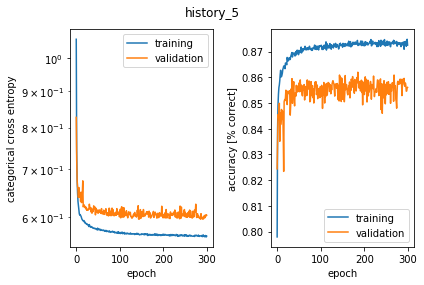

In [21]:
print('Final accuracy for validation data : ' , 100*history_5.history['val_acc'][-1] ,'%')
print('Final accuracy for training data : ' , 100*history_5.history['acc'][-1] ,'%')
plot_history(history_5, 'history_5')
plt.show()

In [15]:
# two hidden layers with regularization l1

from keras import regularizers

epochs = 200

model_5 = Sequential()
model_5.add(Dense(128, activation='relu', input_shape=(784,), kernel_regularizer=regularizers.l1(0.0004)))
model_5.add(Dense(50, activation='relu'))
model_5.add(Dense(num_classes, activation='softmax'))

model_5.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history_5 = model_5.fit(x_fashion_train, y_fashion_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_fashion_test, y_fashion_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 3s 52us/step - loss: 1.2832 - acc: 0.7928 - val_loss: 0.8505 - val_acc: 0.8318
Epoch 2/200
60000/60000 [==============================] - 2s 31us/step - loss: 0.7363 - acc: 0.8345 - val_loss: 0.6868 - val_acc: 0.8338
Epoch 3/200
60000/60000 [==============================] - 2s 29us/step - loss: 0.6334 - acc: 0.8420 - val_loss: 0.6369 - val_acc: 0.8304
Epoch 4/200
60000/60000 [==============================] - 2s 28us/step - loss: 0.5813 - acc: 0.8462 - val_loss: 0.5957 - val_acc: 0.8403
Epoch 5/200
60000/60000 [==============================] - 1s 24us/step - loss: 0.5601 - acc: 0.8502 - val_loss: 0.5734 - val_acc: 0.8446
Epoch 6/200
60000/60000 [==============================] - 1s 22us/step - loss: 0.5390 - acc: 0.8558 - val_loss: 0.5626 - val_acc: 0.8442
Epoch 7/200
60000/60000 [==============================] - 1s 20us/step - loss: 0.5243 - acc: 0.8569 - val_loss: 0.5720 - 

Epoch 118/200
60000/60000 [==============================] - 1s 22us/step - loss: 0.3930 - acc: 0.8899 - val_loss: 0.4511 - val_acc: 0.8747
Epoch 119/200
60000/60000 [==============================] - 1s 22us/step - loss: 0.3943 - acc: 0.8890 - val_loss: 0.4675 - val_acc: 0.8669
Epoch 120/200
60000/60000 [==============================] - 1s 21us/step - loss: 0.3942 - acc: 0.8907 - val_loss: 0.4650 - val_acc: 0.8685
Epoch 121/200
60000/60000 [==============================] - 1s 23us/step - loss: 0.3943 - acc: 0.8904 - val_loss: 0.4996 - val_acc: 0.8584
Epoch 122/200
60000/60000 [==============================] - 1s 24us/step - loss: 0.3916 - acc: 0.8907 - val_loss: 0.4607 - val_acc: 0.8685
Epoch 123/200
60000/60000 [==============================] - 1s 22us/step - loss: 0.3971 - acc: 0.8893 - val_loss: 0.5061 - val_acc: 0.8620
Epoch 124/200
60000/60000 [==============================] - 1s 21us/step - loss: 0.3964 - acc: 0.8897 - val_loss: 0.4712 - val_acc: 0.8647
Epoch 125/200
60000/

Final accuracy for validation data :  86.92999999999999 %
Final accuracy for training data :  89.33166666348775 %


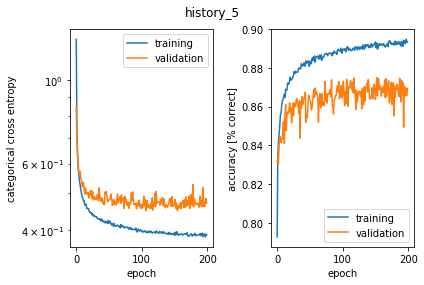

In [16]:
print('Final accuracy for validation data : ' , 100*history_5.history['val_acc'][-1] ,'%')
print('Final accuracy for training data : ' , 100*history_5.history['acc'][-1] ,'%')
plot_history(history_5, 'history_5')
plt.show()

In [17]:
# two hidden layers with regularization l1

from keras import regularizers

epochs = 200

model_5 = Sequential()
model_5.add(Dense(128, activation='relu', input_shape=(784,), kernel_regularizer=regularizers.l1(0.0001)))
model_5.add(Dense(50, activation='relu'))
model_5.add(Dense(num_classes, activation='softmax'))

model_5.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history_5 = model_5.fit(x_fashion_train, y_fashion_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_fashion_test, y_fashion_test))





Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 2s 30us/step - loss: 0.8403 - acc: 0.8058 - val_loss: 0.6775 - val_acc: 0.8383
Epoch 2/200
60000/60000 [==============================] - 1s 24us/step - loss: 0.6123 - acc: 0.8522 - val_loss: 0.6048 - val_acc: 0.8470
Epoch 3/200
60000/60000 [==============================] - 1s 23us/step - loss: 0.5444 - acc: 0.8599 - val_loss: 0.5604 - val_acc: 0.8509
Epoch 4/200
60000/60000 [==============================] - 1s 23us/step - loss: 0.5047 - acc: 0.8661 - val_loss: 0.5457 - val_acc: 0.8469
Epoch 5/200
60000/60000 [==============================] - 1s 24us/step - loss: 0.4750 - acc: 0.8723 - val_loss: 0.4944 - val_acc: 0.8624
Epoch 6/200
60000/60000 [==============================] - 1s 22us/step - loss: 0.4539 - acc: 0.8755 - val_loss: 0.4846 - val_acc: 0.8650
Epoch 7/200
60000/60000 [==============================] - 2s 25us/step - loss: 0.4391 - acc: 0.8770 - val_loss: 0.4629 - 

Epoch 118/200
60000/60000 [==============================] - 1s 20us/step - loss: 0.2998 - acc: 0.9209 - val_loss: 0.4667 - val_acc: 0.8746
Epoch 119/200
60000/60000 [==============================] - 1s 20us/step - loss: 0.2969 - acc: 0.9207 - val_loss: 0.4471 - val_acc: 0.8774
Epoch 120/200
60000/60000 [==============================] - 1s 20us/step - loss: 0.2960 - acc: 0.9217 - val_loss: 0.4426 - val_acc: 0.8816
Epoch 121/200
60000/60000 [==============================] - 1s 21us/step - loss: 0.3030 - acc: 0.9189 - val_loss: 0.4576 - val_acc: 0.8770
Epoch 122/200
60000/60000 [==============================] - 1s 25us/step - loss: 0.2933 - acc: 0.9223 - val_loss: 0.4414 - val_acc: 0.8846
Epoch 123/200
60000/60000 [==============================] - 1s 23us/step - loss: 0.2949 - acc: 0.9222 - val_loss: 0.4777 - val_acc: 0.8710
Epoch 124/200
60000/60000 [==============================] - 1s 24us/step - loss: 0.2962 - acc: 0.9214 - val_loss: 0.4387 - val_acc: 0.8836
Epoch 125/200
60000/

Final accuracy for validation data :  88.08 %
Final accuracy for training data :  92.74166666348775 %


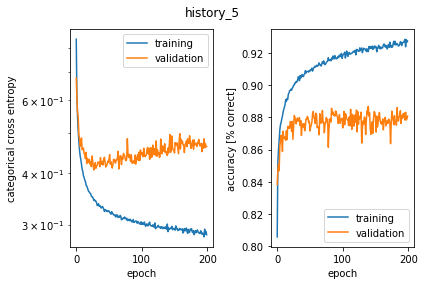

Best accuracy for validation data :  0.8869 %


In [19]:
print('Final accuracy for validation data : ' , 100*history_5.history['val_acc'][-1] ,'%')
print('Final accuracy for training data : ' , 100*history_5.history['acc'][-1] ,'%')
plot_history(history_5, 'history_5')
plt.show()
print('Best accuracy for validation data : ' , max(100*history_5.history['val_acc']) ,'%')

In [29]:
# two hidden layers with batch normalization and l1

from keras.layers import BatchNormalization , Activation

epochs = 200

model_5 = Sequential()

model_5.add(Dense(128, input_shape=(784,), kernel_regularizer=regularizers.l1(0.0001)))
model_5.add(BatchNormalization())
model_5.add(Activation('relu'))


model_5.add(Dense(50))
model_5.add(BatchNormalization())
model_5.add(Activation('relu'))


model_5.add(Dense(num_classes))
model_5.add(BatchNormalization())
model_5.add(Activation('softmax'))



model_5.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history_5 = model_5.fit(x_fashion_train, y_fashion_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_fashion_test, y_fashion_test))



Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 4s 64us/step - loss: 0.9544 - acc: 0.8310 - val_loss: 0.8060 - val_acc: 0.8400
Epoch 2/200
60000/60000 [==============================] - 2s 32us/step - loss: 0.6368 - acc: 0.8695 - val_loss: 0.6495 - val_acc: 0.8570
Epoch 3/200
60000/60000 [==============================] - 2s 32us/step - loss: 0.5357 - acc: 0.8750 - val_loss: 0.5789 - val_acc: 0.8551
Epoch 4/200
60000/60000 [==============================] - 2s 32us/step - loss: 0.4945 - acc: 0.8794 - val_loss: 0.5976 - val_acc: 0.8455
Epoch 5/200
60000/60000 [==============================] - 2s 33us/step - loss: 0.4668 - acc: 0.8826 - val_loss: 0.5501 - val_acc: 0.8563
Epoch 6/200
60000/60000 [==============================] - 2s 32us/step - loss: 0.4472 - acc: 0.8868 - val_loss: 0.5437 - val_acc: 0.8489
Epoch 7/200
60000/60000 [==============================] - 2s 32us/step - loss: 0.4362 - acc: 0.8873 - val_loss: 0.7570 - 

Epoch 118/200
60000/60000 [==============================] - 2s 34us/step - loss: 0.2975 - acc: 0.9330 - val_loss: 0.6106 - val_acc: 0.8448
Epoch 119/200
60000/60000 [==============================] - 2s 37us/step - loss: 0.2976 - acc: 0.9340 - val_loss: 0.5326 - val_acc: 0.8692
Epoch 120/200
60000/60000 [==============================] - 2s 35us/step - loss: 0.2985 - acc: 0.9337 - val_loss: 0.5194 - val_acc: 0.8722
Epoch 121/200
60000/60000 [==============================] - 2s 35us/step - loss: 0.2991 - acc: 0.9325 - val_loss: 0.5219 - val_acc: 0.8690
Epoch 122/200
60000/60000 [==============================] - 2s 32us/step - loss: 0.2945 - acc: 0.9348 - val_loss: 0.5358 - val_acc: 0.8631
Epoch 123/200
60000/60000 [==============================] - 2s 35us/step - loss: 0.2964 - acc: 0.9340 - val_loss: 0.5358 - val_acc: 0.8642
Epoch 124/200
60000/60000 [==============================] - 2s 34us/step - loss: 0.2976 - acc: 0.9333 - val_loss: 0.5798 - val_acc: 0.8529
Epoch 125/200
60000/

Final accuracy for validation data :  88.11 %
Final accuracy for training data :  98.6 %
Best accuracy for validation data :  0.8909 %


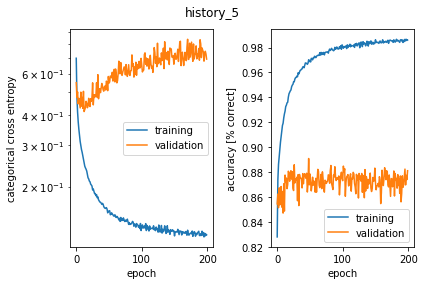

In [28]:
print('Final accuracy for validation data : ' , 100*history_5.history['val_acc'][-1] ,'%')
print('Final accuracy for training data : ' , 100*history_5.history['acc'][-1] ,'%')

print('Best accuracy for validation data : ' , max(100*history_5.history['val_acc']) ,'%')
plot_history(history_5, 'history_5')
plt.show()

In [19]:
# two hidden layers with Dropout

epochs = 300

model_5 = Sequential()
model_5.add(Dense(128, activation='relu', input_shape=(784,)))
model_5.add(Dropout(0.2))
model_5.add(Dense(50, activation='relu'))
model_5.add(Dropout(0.2))
model_5.add(Dense(num_classes, activation='softmax'))

model_5.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history_5 = model_5.fit(x_fashion_train, y_fashion_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_fashion_test, y_fashion_test))



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 60000 samples, validate on 10000 samples
Epoch 1/300
60000/60000 [==============================] - 5s 77us/step - loss: 0.6759 - acc: 0.7650 - val_loss: 0.4523 - val_acc: 0.8371
Epoch 2/300
60000/60000 [==============================] - 2s 26us/step - loss: 0.4519 - acc: 0.8402 - val_loss: 0.4068 - val_acc: 0.8533
Epoch 3/300
60000/60000 [==============================] - 2s 27us/step - loss: 0.4078 - acc: 0.8540 - val_loss: 0.3964 - val_acc: 0.8553
Epoch 4/300
60000/60000 [==============================] - 1s 25us/step - loss: 0.3827 - acc: 0.8607 - val_loss: 0.3762 - val_acc: 0.8670
Epoch 5/300
60000/60000 [==============================] - 2s 25us/step - loss: 0.3634 - acc: 0.8689 - val_loss: 0.3614 - val_acc: 0.8723
Epoch 6/300
60000/60000 [==============================] - 2s 28us/step - loss: 0.3489 - acc: 0.8745 - val_loss: 0.3527 - val_acc: 0.8737
Epoch 7

Epoch 116/300
60000/60000 [==============================] - 2s 29us/step - loss: 0.1471 - acc: 0.9435 - val_loss: 0.3925 - val_acc: 0.8981
Epoch 117/300
60000/60000 [==============================] - 2s 28us/step - loss: 0.1419 - acc: 0.9461 - val_loss: 0.3911 - val_acc: 0.8952
Epoch 118/300
60000/60000 [==============================] - 2s 30us/step - loss: 0.1477 - acc: 0.9439 - val_loss: 0.3856 - val_acc: 0.8952
Epoch 119/300
60000/60000 [==============================] - ETA: 0s - loss: 0.1453 - acc: 0.9453- ETA: 0s - loss: 0 - 2s 28us/step - loss: 0.1458 - acc: 0.9451 - val_loss: 0.3816 - val_acc: 0.8950
Epoch 120/300
60000/60000 [==============================] - 2s 28us/step - loss: 0.1418 - acc: 0.9464 - val_loss: 0.3827 - val_acc: 0.8957
Epoch 121/300
60000/60000 [==============================] - 2s 28us/step - loss: 0.1443 - acc: 0.9462 - val_loss: 0.3912 - val_acc: 0.8963
Epoch 122/300
60000/60000 [==============================] - 2s 26us/step - loss: 0.1405 - acc: 0.9473

60000/60000 [==============================] - 2s 29us/step - loss: 0.1044 - acc: 0.9604 - val_loss: 0.4842 - val_acc: 0.8931
Epoch 233/300
60000/60000 [==============================] - 2s 27us/step - loss: 0.1082 - acc: 0.9590 - val_loss: 0.4693 - val_acc: 0.8946
Epoch 234/300
60000/60000 [==============================] - 2s 27us/step - loss: 0.1043 - acc: 0.9606 - val_loss: 0.4727 - val_acc: 0.8939
Epoch 235/300
60000/60000 [==============================] - 2s 26us/step - loss: 0.1111 - acc: 0.9582 - val_loss: 0.4762 - val_acc: 0.8892
Epoch 236/300
60000/60000 [==============================] - 2s 29us/step - loss: 0.1099 - acc: 0.9594 - val_loss: 0.4830 - val_acc: 0.8928
Epoch 237/300
60000/60000 [==============================] - 2s 35us/step - loss: 0.1082 - acc: 0.9588 - val_loss: 0.4589 - val_acc: 0.8956
Epoch 238/300
60000/60000 [==============================] - 2s 31us/step - loss: 0.1054 - acc: 0.9602 - val_loss: 0.4737 - val_acc: 0.8975
Epoch 239/300
60000/60000 [=======

Final accuracy for validation data :  89.44 %
Final accuracy for training data :  96.48166666984558 %
Best accuracy for validation data :  0.8994 %


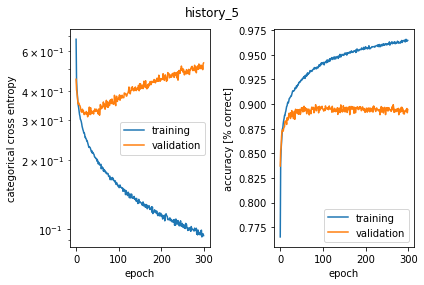

In [20]:
print('Final accuracy for validation data : ' , 100*history_5.history['val_acc'][-1] ,'%')
print('Final accuracy for training data : ' , 100*history_5.history['acc'][-1] ,'%')

print('Best accuracy for validation data : ' , max(100*history_5.history['val_acc']) ,'%')
plot_history(history_5, 'history_5')
plt.show()

In [31]:
# two hidden layers with Dropout and kernel constraint

from keras.constraints import maxnorm

epochs = 200

model_5 = Sequential()
model_5.add(Dense(128, activation='relu', input_shape=(784,), kernel_constraint=maxnorm(3)))
model_5.add(Dropout(0.1))
model_5.add(Dense(50, activation='relu', kernel_constraint=maxnorm(3)))
model_5.add(Dropout(0.1))
model_5.add(Dense(num_classes, activation='softmax', kernel_constraint=maxnorm(3)))

model_5.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history_5 = model_5.fit(x_fashion_train, y_fashion_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_fashion_test, y_fashion_test))




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 4s 65us/step - loss: 0.6169 - acc: 0.7835 - val_loss: 0.4276 - val_acc: 0.8460
Epoch 2/200
60000/60000 [==============================] - 2s 27us/step - loss: 0.4107 - acc: 0.8530 - val_loss: 0.4094 - val_acc: 0.8517
Epoch 3/200
60000/60000 [==============================] - 2s 26us/step - loss: 0.3708 - acc: 0.8648 - val_loss: 0.3711 - val_acc: 0.8660
Epoch 4/200
60000/60000 [==============================] - 2s 27us/step - loss: 0.3505 - acc: 0.8734 - val_loss: 0.3707 - val_acc: 0.8637
Epoch 5/200
60000/60000 [==============================] - 2s 26us/step - loss: 0.3295 - acc: 0.8800 - val_loss: 0.3547 - val_acc: 0.8734
Epoch 6/200
60000/60000 [==============================] - 2s 27us/step - loss: 0.3178 - acc: 0.8823 - val_loss: 0.3495 - val_acc: 0.8780
Epoch 7

Epoch 116/200
60000/60000 [==============================] - 2s 27us/step - loss: 0.1832 - acc: 0.9303 - val_loss: 0.3249 - val_acc: 0.8930
Epoch 117/200
60000/60000 [==============================] - 2s 27us/step - loss: 0.1824 - acc: 0.9306 - val_loss: 0.3307 - val_acc: 0.8877
Epoch 118/200
60000/60000 [==============================] - 2s 28us/step - loss: 0.1792 - acc: 0.9318 - val_loss: 0.3367 - val_acc: 0.8862
Epoch 119/200
60000/60000 [==============================] - 2s 28us/step - loss: 0.1807 - acc: 0.9310 - val_loss: 0.3340 - val_acc: 0.8909
Epoch 120/200
60000/60000 [==============================] - 2s 27us/step - loss: 0.1791 - acc: 0.9328 - val_loss: 0.3431 - val_acc: 0.8904
Epoch 121/200
60000/60000 [==============================] - 2s 28us/step - loss: 0.1800 - acc: 0.9305 - val_loss: 0.3424 - val_acc: 0.8871
Epoch 122/200
60000/60000 [==============================] - 2s 26us/step - loss: 0.1828 - acc: 0.9303 - val_loss: 0.3402 - val_acc: 0.8867
Epoch 123/200
60000/

Final accuracy for validation data :  88.67 %
Final accuracy for training data :  91.96833333651225 %
Best accuracy for validation data :  0.8957 %


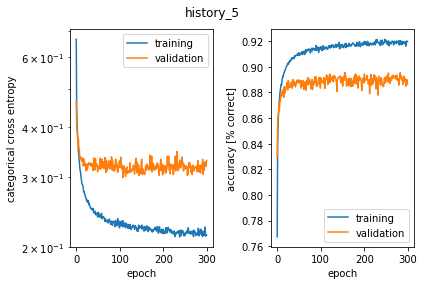

In [23]:
print('Final accuracy for validation data : ' , 100*history_5.history['val_acc'][-1] ,'%')
print('Final accuracy for training data : ' , 100*history_5.history['acc'][-1] ,'%')

print('Best accuracy for validation data : ' , max(100*history_5.history['val_acc']) ,'%')
plot_history(history_5, 'history_5')
plt.show()

In [198]:
# two hidden layers with Dropout and bias regularization

from keras.constraints import maxnorm

epochs = 200

model_5 = Sequential()
model_5.add(Dense(128, activation='relu', input_shape=(784,), kernel_constraint=maxnorm(3), bias_regularizer=regularizers.l1(0.000001)))
model_5.add(Dropout(0.1))
model_5.add(Dense(50, activation='relu', kernel_constraint=maxnorm(3), bias_regularizer=regularizers.l1(0.000001)))
model_5.add(Dropout(0.1))
model_5.add(Dense(num_classes, activation='softmax', kernel_constraint=maxnorm(3), bias_regularizer=regularizers.l1(0.000001)))

model_5.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history_5 = model_5.fit(x_fashion_train, y_fashion_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_fashion_test, y_fashion_test))




Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 17s 287us/step - loss: 0.6332 - acc: 0.7796 - val_loss: 0.4446 - val_acc: 0.8405
Epoch 2/200
60000/60000 [==============================] - 3s 53us/step - loss: 0.4220 - acc: 0.8503 - val_loss: 0.3894 - val_acc: 0.8604
Epoch 3/200
60000/60000 [==============================] - 3s 47us/step - loss: 0.3779 - acc: 0.8641 - val_loss: 0.4206 - val_acc: 0.8458
Epoch 4/200
60000/60000 [==============================] - 3s 46us/step - loss: 0.3489 - acc: 0.8728 - val_loss: 0.3620 - val_acc: 0.8702
Epoch 5/200
60000/60000 [==============================] - 2s 40us/step - loss: 0.3305 - acc: 0.8787 - val_loss: 0.3785 - val_acc: 0.8612
Epoch 6/200
60000/60000 [==============================] - 3s 44us/step - loss: 0.3175 - acc: 0.8836 - val_loss: 0.3414 - val_acc: 0.8762
Epoch 7/200
60000/60000 [==============================] - 2s 34us/step - loss: 0.3085 - acc: 0.8848 - val_loss: 0.3568 

Epoch 118/200
60000/60000 [==============================] - 3s 50us/step - loss: 0.1808 - acc: 0.9328 - val_loss: 0.3446 - val_acc: 0.8915
Epoch 119/200
60000/60000 [==============================] - 2s 40us/step - loss: 0.1808 - acc: 0.9314 - val_loss: 0.3267 - val_acc: 0.8921
Epoch 120/200
60000/60000 [==============================] - 2s 33us/step - loss: 0.1810 - acc: 0.9320 - val_loss: 0.3227 - val_acc: 0.8928
Epoch 121/200
60000/60000 [==============================] - 2s 38us/step - loss: 0.1816 - acc: 0.9316 - val_loss: 0.3318 - val_acc: 0.8893
Epoch 122/200
60000/60000 [==============================] - 2s 36us/step - loss: 0.1786 - acc: 0.9324 - val_loss: 0.3280 - val_acc: 0.8913
Epoch 123/200
60000/60000 [==============================] - 2s 33us/step - loss: 0.1833 - acc: 0.9296 - val_loss: 0.3475 - val_acc: 0.8845
Epoch 124/200
60000/60000 [==============================] - 2s 33us/step - loss: 0.1814 - acc: 0.9320 - val_loss: 0.3171 - val_acc: 0.8928
Epoch 125/200
60000/

Final accuracy for validation data :  88.77000000000001 %
Final accuracy for training data :  93.67666666984557 %
Best accuracy for validation data :  0.8974 %


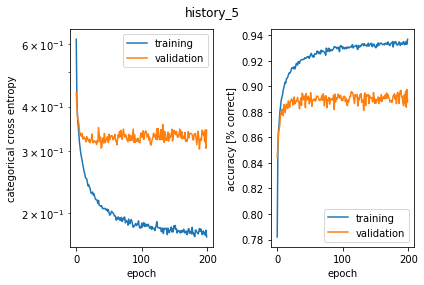

In [33]:
print('Final accuracy for validation data : ' , 100*history_5.history['val_acc'][-1] ,'%')
print('Final accuracy for training data : ' , 100*history_5.history['acc'][-1] ,'%')

print('Best accuracy for validation data : ' , max(100*history_5.history['val_acc']) ,'%')
plot_history(history_5, 'history_5')
plt.show()

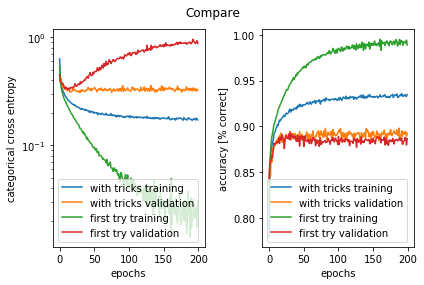

In [244]:
fig = comparison_plot(history_5, history_5_first , 'with tricks' , 'first try' , 'Compare')



Answer to question 2 (comments): we can see in the above plot that the validation accuracy of the network with tricks (Droupout + regularization) is a bit better than the first network(without tricks), in addition the sign of overfitting is stronger in the first network as we used the tricks to prevent overfitting. also both of this 2 hidden layer networks are better than the one hidden layer network.

In [34]:
# The best on  MNIS

epochs = 300

model_5 = Sequential()
model_5.add(Dense(128, activation='relu', input_shape=(784,)))
model_5.add(Dropout(0.2))
model_5.add(Dense(50, activation='relu'))
model_5.add(Dropout(0.2))
model_5.add(Dense(num_classes, activation='softmax'))

model_5.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history_5 = model_5.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))



Train on 60000 samples, validate on 10000 samples
Epoch 1/300
60000/60000 [==============================] - 4s 74us/step - loss: 0.4675 - acc: 0.8570 - val_loss: 0.1745 - val_acc: 0.9475
Epoch 2/300
60000/60000 [==============================] - 2s 27us/step - loss: 0.2072 - acc: 0.9386 - val_loss: 0.1282 - val_acc: 0.9601
Epoch 3/300
60000/60000 [==============================] - 2s 25us/step - loss: 0.1582 - acc: 0.9543 - val_loss: 0.0983 - val_acc: 0.9699
Epoch 4/300
60000/60000 [==============================] - 2s 27us/step - loss: 0.1281 - acc: 0.9615 - val_loss: 0.0921 - val_acc: 0.9715
Epoch 5/300
60000/60000 [==============================] - 2s 27us/step - loss: 0.1078 - acc: 0.9682 - val_loss: 0.0861 - val_acc: 0.9740
Epoch 6/300
60000/60000 [==============================] - 2s 28us/step - loss: 0.0962 - acc: 0.9707 - val_loss: 0.0811 - val_acc: 0.9768
Epoch 7/300
60000/60000 [==============================] - 2s 27us/step - loss: 0.0884 - acc: 0.9733 - val_loss: 0.0761 - 

Epoch 118/300
60000/60000 [==============================] - 1s 25us/step - loss: 0.0129 - acc: 0.9957 - val_loss: 0.0992 - val_acc: 0.9833
Epoch 119/300
60000/60000 [==============================] - 1s 25us/step - loss: 0.0145 - acc: 0.9956 - val_loss: 0.1068 - val_acc: 0.9816
Epoch 120/300
60000/60000 [==============================] - 1s 25us/step - loss: 0.0152 - acc: 0.9948 - val_loss: 0.1063 - val_acc: 0.9815
Epoch 121/300
60000/60000 [==============================] - 2s 28us/step - loss: 0.0159 - acc: 0.9948 - val_loss: 0.1028 - val_acc: 0.9825
Epoch 122/300
60000/60000 [==============================] - 2s 30us/step - loss: 0.0144 - acc: 0.9959 - val_loss: 0.1025 - val_acc: 0.9828
Epoch 123/300
60000/60000 [==============================] - 2s 27us/step - loss: 0.0132 - acc: 0.9958 - val_loss: 0.1035 - val_acc: 0.9823
Epoch 124/300
60000/60000 [==============================] - 2s 27us/step - loss: 0.0147 - acc: 0.9953 - val_loss: 0.1101 - val_acc: 0.9825
Epoch 125/300
60000/

60000/60000 [==============================] - 2s 25us/step - loss: 0.0098 - acc: 0.9968 - val_loss: 0.1201 - val_acc: 0.9810
Epoch 235/300
60000/60000 [==============================] - 1s 25us/step - loss: 0.0100 - acc: 0.9967 - val_loss: 0.1154 - val_acc: 0.9825
Epoch 236/300
60000/60000 [==============================] - 1s 25us/step - loss: 0.0103 - acc: 0.9967 - val_loss: 0.1107 - val_acc: 0.9816
Epoch 237/300
60000/60000 [==============================] - 1s 25us/step - loss: 0.0105 - acc: 0.9968 - val_loss: 0.1180 - val_acc: 0.9815
Epoch 238/300
60000/60000 [==============================] - 1s 25us/step - loss: 0.0101 - acc: 0.9967 - val_loss: 0.1219 - val_acc: 0.9815
Epoch 239/300
60000/60000 [==============================] - 1s 25us/step - loss: 0.0107 - acc: 0.9969 - val_loss: 0.1164 - val_acc: 0.9829
Epoch 240/300
60000/60000 [==============================] - 1s 25us/step - loss: 0.0103 - acc: 0.9970 - val_loss: 0.1117 - val_acc: 0.9823
Epoch 241/300
60000/60000 [=======

Final accuracy for validation data :  89.25999999999999 %
Final accuracy for training data :  93.48500000317892 %
Best accuracy for validation data :  0.8982 %


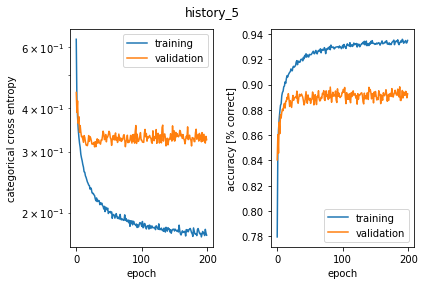

In [199]:
print('Final accuracy for validation data : ' , 100*history_5.history['val_acc'][-1] ,'%')
print('Final accuracy for training data : ' , 100*history_5.history['acc'][-1] ,'%')

print('Best accuracy for validation data : ' , max(100*history_5.history['val_acc']) ,'%')
plot_history(history_5, 'history_5')
plt.show()

## Exercise 6: Convolutional neural networks (CNNs) (10 points)

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with different architectures and parameters. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples). (4 pts)
2. Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST. (4 pts)
3. How does the CNN performance compare to the so far best performing (deep) neural network model for the two data sets? (2 sentences max.) (2 pts)

### Solution

In [209]:
from keras import backend as K

### We did data loading and preparation again to be able to run this cnn independent of previous Blocks

In [210]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()


if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    
    x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0],1,img_rows,img_cols)
    x_fashion_test  = x_fashion_test.reshape(x_fashion_test.shape[0],1,img_rows,img_cols)
    
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    
    x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0],img_rows,img_cols,1)
    x_fashion_test  = x_fashion_test.reshape(x_fashion_test.shape[0],img_rows,img_cols,1)
    
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_fashion_train = x_fashion_train.astype('float32')
x_fashion_test  = x_fashion_test.astype('float32')
x_fashion_train /=255
x_fashion_test /=255


print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [211]:
print(input_shape)

(28, 28, 1)


In [212]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(num_classes, activation='softmax'))

cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_158 (Dense)            (None, 128)               1179776   
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
__________

In [154]:
cnn_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [155]:
cnn_history = cnn_model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 137s 2ms/step - loss: 0.2558 - acc: 0.9206 - val_loss: 0.0534 - val_acc: 0.9819
Epoch 2/12
60000/60000 [==============================] - 118s 2ms/step - loss: 0.0867 - acc: 0.9742 - val_loss: 0.0445 - val_acc: 0.9845
Epoch 3/12
60000/60000 [==============================] - 115s 2ms/step - loss: 0.0661 - acc: 0.9812 - val_loss: 0.0344 - val_acc: 0.9880
Epoch 4/12
60000/60000 [==============================] - 113s 2ms/step - loss: 0.0541 - acc: 0.9837 - val_loss: 0.0342 - val_acc: 0.9874
Epoch 5/12
60000/60000 [==============================] - 113s 2ms/step - loss: 0.0488 - acc: 0.9855 - val_loss: 0.0287 - val_acc: 0.9904
Epoch 6/12
60000/60000 [==============================] - 130s 2ms/step - loss: 0.0431 - acc: 0.9871 - val_loss: 0.0282 - val_acc: 0.9911
Epoch 7/12
60000/60000 [==============================] - 124s 2ms/step - loss: 0.0368 - acc: 0.9892 - val_loss: 0.0303 - 

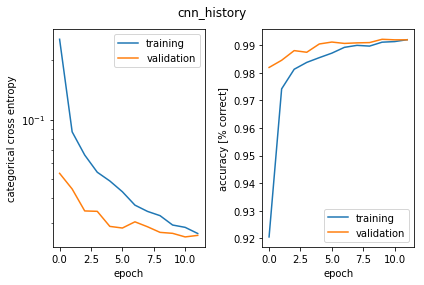

In [156]:
plot_history(cnn_history, 'cnn_history')
plt.show()

#### CNN new with kernel size 5

In [225]:
cnn_model_new = Sequential()
cnn_model_new.add(Conv2D(32, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=input_shape))
cnn_model_new.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model_new.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_new.add(Dropout(0.25))
cnn_model_new.add(Flatten())
cnn_model_new.add(Dense(128, activation='relu'))
cnn_model_new.add(Dropout(0.5))
cnn_model_new.add(Dense(num_classes, activation='softmax'))

cnn_model_new.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dense_164 (Dense)            (None, 128)               991360    
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
__________

In [226]:
cnn_model_new.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [227]:
cnn_history_new = cnn_model_new.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 120s 2ms/step - loss: 0.2414 - acc: 0.9262 - val_loss: 0.0640 - val_acc: 0.9799
Epoch 2/12
60000/60000 [==============================] - 102s 2ms/step - loss: 0.0820 - acc: 0.9755 - val_loss: 0.0380 - val_acc: 0.9861
Epoch 3/12
60000/60000 [==============================] - 102s 2ms/step - loss: 0.0644 - acc: 0.9809 - val_loss: 0.0335 - val_acc: 0.9884
Epoch 4/12
60000/60000 [==============================] - 104s 2ms/step - loss: 0.0533 - acc: 0.9843 - val_loss: 0.0318 - val_acc: 0.9898
Epoch 5/12
60000/60000 [==============================] - 100s 2ms/step - loss: 0.0454 - acc: 0.9862 - val_loss: 0.0293 - val_acc: 0.9902
Epoch 6/12
60000/60000 [==============================] - 101s 2ms/step - loss: 0.0398 - acc: 0.9883 - val_loss: 0.0237 - val_acc: 0.9923
Epoch 7/12
60000/60000 [==============================] - 100s 2ms/step - loss: 0.0363 - acc: 0.9885 - val_loss: 0.0271 - 

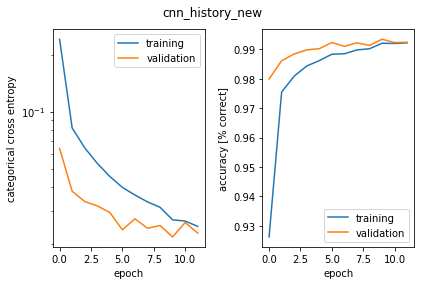

In [228]:
plot_history(cnn_history_new, 'cnn_history_new')
plt.show()

## CNN on Fashion MNIST

In [157]:
cnn_model_fashion = Sequential()
cnn_model_fashion.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
cnn_model_fashion.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model_fashion.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_fashion.add(Dropout(0.25))
cnn_model_fashion.add(Flatten())
cnn_model_fashion.add(Dense(128, activation='relu'))
cnn_model_fashion.add(Dropout(0.5))
cnn_model_fashion.add(Dense(num_classes, activation='softmax'))

cnn_model_fashion.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_139 (Dense)            (None, 128)               1179776   
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
__________

In [158]:
cnn_model_fashion.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [159]:
cnn_history_fashion = cnn_model_fashion.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 115s 2ms/step - loss: 0.2588 - acc: 0.9185 - val_loss: 0.0606 - val_acc: 0.9803
Epoch 2/12
60000/60000 [==============================] - 112s 2ms/step - loss: 0.0933 - acc: 0.9726 - val_loss: 0.0463 - val_acc: 0.9849
Epoch 3/12
60000/60000 [==============================] - 111s 2ms/step - loss: 0.0674 - acc: 0.9794 - val_loss: 0.0363 - val_acc: 0.9873
Epoch 4/12
60000/60000 [==============================] - 110s 2ms/step - loss: 0.0550 - acc: 0.9834 - val_loss: 0.0392 - val_acc: 0.9865
Epoch 5/12
60000/60000 [==============================] - 122s 2ms/step - loss: 0.0485 - acc: 0.9856 - val_loss: 0.0305 - val_acc: 0.9901
Epoch 6/12
60000/60000 [==============================] - 111s 2ms/step - loss: 0.0429 - acc: 0.9871 - val_loss: 0.0319 - val_acc: 0.9890
Epoch 7/12
60000/60000 [==============================] - 115s 2ms/step - loss: 0.0399 - acc: 0.9882 - val_loss: 0.0280 - 

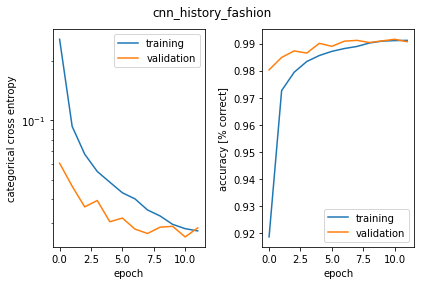

In [160]:
plot_history(cnn_history_fashion, 'cnn_history_fashion')
plt.show()

#### Answer to question 3: The performance of CNN is much better than the Deep networks. CNN is desigend for image tasks and it learns to recognize components of an image (e.g., lines, curves, etc.) and then learn to combine these components to recognize larger structures (e.g., objects, faces, etc.).

## Exercise 7: Sigmoidal activation function and batch-normalization (6 points)

### Description:

In the original publication of batch normalization [Ioffe and Szegedy, 2014](https://arxiv.org/pdf/1502.03167.pdf), the authors mention a particularly beneficial effect of their method on networks with sigmoidal activation functions. This is because such networks usually suffer from saturating activations/vanishing gradients. Here we want to reproduce this behaviour (Chose either MNIST or Fashion-MNIST for this exercise).

1. Implement the same convolutional network as in the previous exercise, but using the sigmoid activation function instead of the standard choice ReLU. Train the network for a reasonable amount of time. What do you observe? (1 sentence max.) (3 pts)
2. Add batch-normalization layers to all convolutional and fully-connected layers (i.e. before each layer with learnable parameters). How does the performance change? Can the network reach the ReLU-CNN performance of the previous exercise? (1 sentence max.) (3 pts)
3. **BONUS (optional, not graded**): Investigate our initial guess that saturating activity/vanishing gradients might be the cause of this behaviour. For that, create histograms of the hidden activitions for different hidden layers for the sigmoid-CNN and the sigmoid-CNN with batch-normalization (counting over both, samples and neurons per layer). You may only chose layers with learnable parameters. What do you observe?
Hint: You can use the [keract](https://github.com/philipperemy/keract) package to access neural activation values for all layers of your network model.



### Solution:

In [200]:
sig_cnn_model = Sequential()
sig_cnn_model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='sigmoid',
                 input_shape=input_shape))
sig_cnn_model.add(Conv2D(64, (3, 3), activation='sigmoid'))
sig_cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
sig_cnn_model.add(Dropout(0.25))
sig_cnn_model.add(Flatten())
sig_cnn_model.add(Dense(128, activation='sigmoid'))
sig_cnn_model.add(Dropout(0.5))
sig_cnn_model.add(Dense(num_classes, activation='softmax'))

sig_cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_156 (Dense)            (None, 128)               1179776   
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
__________

In [201]:
sig_cnn_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [ ]:
sig_cnn_history = sig_cnn_model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 130s 2ms/step - loss: 2.3196 - acc: 0.1084 - val_loss: 2.3010 - val_acc: 0.1135
Epoch 2/12
60000/60000 [==============================] - 109s 2ms/step - loss: 2.3017 - acc: 0.1116 - val_loss: 2.3007 - val_acc: 0.1135
Epoch 3/12
60000/60000 [==============================] - 117s 2ms/step - loss: 1.5999 - acc: 0.4095 - val_loss: 0.3413 - val_acc: 0.9027
Epoch 4/12
60000/60000 [==============================] - 106s 2ms/step - loss: 0.3635 - acc: 0.8930 - val_loss: 0.2221 - val_acc: 0.9361
Epoch 5/12
60000/60000 [==============================] - 108s 2ms/step - loss: 0.2800 - acc: 0.9159 - val_loss: 0.1831 - val_acc: 0.9463
Epoch 6/12
60000/60000 [==============================] - 117s 2ms/step - loss: 0.2385 - acc: 0.9307 - val_loss: 0.1594 - val_acc: 0.9497
Epoch 7/12
60000/60000 [==============================] - 115s 2ms/step - loss: 0.2141 - acc: 0.9377 - val_loss: 0.1376 - 

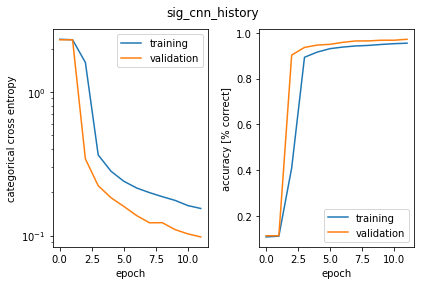

In [217]:
plot_history(sig_cnn_history, 'sig_cnn_history')
plt.show()

#### 7.2

In [220]:
from keras.layers import BatchNormalization
sig_cnn_bn_model = Sequential()



sig_cnn_bn_model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='sigmoid',
                 input_shape=input_shape))
sig_cnn_bn_model.add(BatchNormalization())

sig_cnn_bn_model.add(Conv2D(64, (3, 3), activation='sigmoid'))
sig_cnn_bn_model.add(BatchNormalization())

sig_cnn_bn_model.add(MaxPooling2D(pool_size=(2, 2)))
sig_cnn_bn_model.add(Dropout(0.25))
sig_cnn_bn_model.add(Flatten())
sig_cnn_bn_model.add(Dense(128, activation='sigmoid'))
sig_cnn_bn_model.add(BatchNormalization())

sig_cnn_bn_model.add(Dropout(0.5))
sig_cnn_bn_model.add(Dense(num_classes, activation='softmax'))

sig_cnn_bn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_21 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
batch_normalization_22 (Batc (None, 24, 24, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 9216)              0         
__________

In [222]:
sig_cnn_bn_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [223]:
sig_cnn_bn_history = sig_cnn_model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 131s 2ms/step - loss: 0.0821 - acc: 0.9757 - val_loss: 0.0547 - val_acc: 0.9834
Epoch 2/12
60000/60000 [==============================] - 117s 2ms/step - loss: 0.0791 - acc: 0.9764 - val_loss: 0.0525 - val_acc: 0.9839
Epoch 3/12
60000/60000 [==============================] - 121s 2ms/step - loss: 0.0754 - acc: 0.9774 - val_loss: 0.0586 - val_acc: 0.9818
Epoch 4/12
60000/60000 [==============================] - 120s 2ms/step - loss: 0.0735 - acc: 0.9780 - val_loss: 0.0549 - val_acc: 0.9830
Epoch 5/12
60000/60000 [==============================] - 121s 2ms/step - loss: 0.0739 - acc: 0.9776 - val_loss: 0.0492 - val_acc: 0.9838
Epoch 6/12
60000/60000 [==============================] - 123s 2ms/step - loss: 0.0687 - acc: 0.9795 - val_loss: 0.0478 - val_acc: 0.9845
Epoch 7/12
60000/60000 [==============================] - 116s 2ms/step - loss: 0.0691 - acc: 0.9794 - val_loss: 0.0513 - 

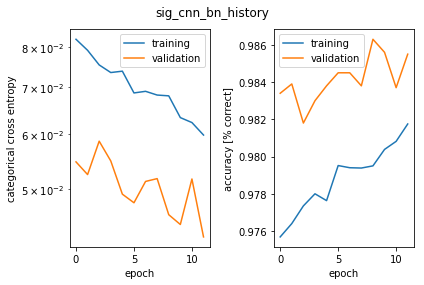

In [224]:
plot_history(sig_cnn_bn_history, 'sig_cnn_bn_history')
plt.show()

#### Answer to question 1:  with sigmoid activation the performance of the networks drops both in the rate of convergence and the final validation accuracy. the reason of this phenomenon is the vanishing gradient. As it is shown in the following figure:

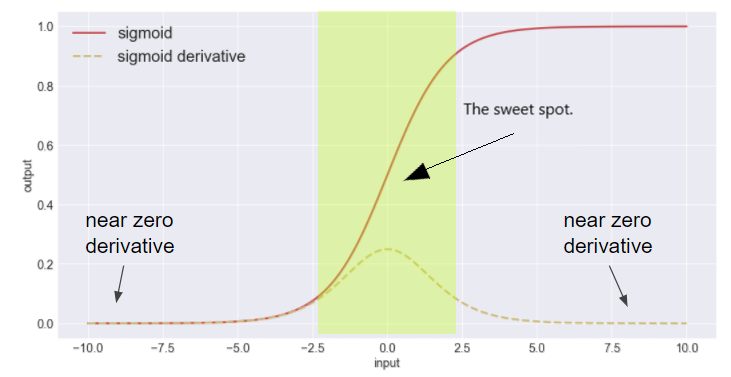

In [248]:
from IPython.display import Image
Image("f1.png")

#### Answer to question 2: the performance of the network with sigmoid activation and batch normalization is better than the network without batch normalization and it is comparable with the result of the ReLU network. the reason is that batch normalization solves the vanishing gradient problem by mapping the range of the input of layers to the interval that the derivative of the sigmoid is big enough so the model trains faster and the final result is better.